In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from time import time
from scipy.signal import convolve2d
from scipy.optimize import curve_fit

In [2]:
def fill_lattice_random(lattice, N):
    lattice = np.copy(lattice)
    d=len(lattice.shape)
    L=lattice.shape[0]
    count=0
    while count < N:
        ind = tuple(np.random.randint(0,L,d))
        if lattice[ind] == 0:
            lattice[ind]=1
            count+=1
    return lattice

In [3]:
def fill_lattice_sparse(lattice, N):
    lattice = np.copy(lattice)
    d=len(lattice.shape)
    if d != 2:
        raise NotImplementedError("fill_lattice_sparce is implemented for d=2 only")
    L=lattice.shape[0]
    count=0
    grid_phase = True
    i = 0
    j = 0
    while count < N:
        if grid_phase:
            lattice[i,j] = 1
            count += 1
            if (j + 2) < L:
                j += 2
            else:
                i += 1
                if i < L:
                    j = i%2
                else:
                    grid_phase = False
        else:
            ind = tuple(np.random.randint(0,L,d))
            if lattice[ind] == 0:
                lattice[ind]=1
                count+=1
    return lattice

In [4]:
def step(lattice):
    # st = time()
    d=len(lattice.shape)
    prev_lattice = np.copy(lattice)
    
    # find all active particles
    # partcles=np.argwhere(lattice==1)
    # partcles_2 = partcles.reshape(partcles.shape + (1,))
    # dists = (np.abs(partcles_2.T-partcles_2)).sum(1)
    # neighbours = np.argwhere(dists==1)
    # actives = partcles[np.unique(neighbours[:,0])]
    star=np.array([[0,1,0],
                   [1,1,1],
                   [0,1,0]])
    active_mat = np.where(lattice, convolve2d(lattice, star, mode='same', boundary='wrap'), 0)
    actives = np.argwhere(active_mat > 1)
    # dT = time()-st
    # dynamics
    neigh_ind_rel = np.array([[1,0],[0,1],[-1,0],[0,-1]])
    for ind in actives:
        neigh_ind = ((neigh_ind_rel + ind) % lattice.shape)
        rand_neigh = np.random.permutation(neigh_ind)
        for neigh in rand_neigh:
            neigh = tuple(neigh)
            if lattice[neigh] == 0 and prev_lattice[neigh] == 0:
            # if lattice[neigh] == 0:
                lattice[neigh] = 1
                lattice[tuple(ind)] = 0
                break
    
    # find all active particles (again)
    active_mat = np.where(lattice, convolve2d(lattice, star, mode='same', boundary='wrap'), 0)
    actives = np.argwhere(active_mat > 1)

    Na = actives.shape[0]
    # dT = time() - st
    return lattice, Na

def simulate(lattice, N):
    # phi_a_min = 1
    # count=0
    # total_steps=0
    # while count < 20:
    #     lattice, phi_a = step(lattice)
    #     total_steps += 1
    #     count += 1
    #     if phi_a == 0:
    #         return lattice, phi_a, total_steps
    #     if phi_a < phi_a_min:
    #         count=0
    #         phi_a_min = phi_a

    max_tries = 1000
    mean_set = 200
    old_phi_mean = 0
    mean_eps = 1e-4
    total_steps=0
    all_phi_a=[]
    while total_steps < max_tries:
        lattice, Na = step(lattice)
        phi_a = float(Na)/N
        all_phi_a+=[phi_a]
        total_steps += 1
        
        if phi_a == 0:
            return lattice, all_phi_a, total_steps, False
        
        phi_mean = np.mean(all_phi_a[-mean_set:])
        if np.abs(old_phi_mean-phi_mean) < mean_eps:
            return lattice, all_phi_a, total_steps, False
        old_phi_mean = phi_mean
    
    return lattice, all_phi_a, total_steps, total_steps >= max_tries

In [5]:
def get_stable_config(L,d,N):
    lattice = np.zeros((L,)*d)
    lattice = fill_lattice_random(lattice, N)
    lattice, all_phi_a, total_steps, reached_max = simulate(lattice, N)
    return lattice, all_phi_a, total_steps, reached_max

In [6]:
L=64
d=2

In [7]:
0.255*(L**d)

1044.48

In [8]:
# N_space = np.arange(880,1045,1)
# N_space = np.arange(1,880,10)
# N_space = np.arange(1045,1545,10)
N_space = np.arange(1545,2048,10)
# N_space = np.concatenate([np.arange(700,825,10),np.arange(825,850,1),np.arange(850,1000,10)])
# N_space = save3['N_space3']
PHI = N_space/(L**d)

In [425]:
np.random.seed(42)
configs_num=25
PHI_A=[]
T=[]
for N in tqdm(N_space):
    phi_a_avg=0
    tot_steps_avg=0
    for i in range(configs_num):
        lattice, all_phi_a, total_steps, reached_max = get_stable_config(L,d,N)
        if all_phi_a[-1] != 0:
            phi_a_avg += np.mean(all_phi_a[-200:])
        if reached_max:
            tot_steps_avg += 1+np.argwhere(np.abs(all_phi_a-np.mean(all_phi_a)) < 1/100 * np.mean(all_phi_a))[0]
        else:
            tot_steps_avg += total_steps
    phi_a_avg /= configs_num
    tot_steps_avg /= configs_num
    PHI_A += [phi_a_avg]
    T += [tot_steps_avg]
PHI_A = np.array(PHI_A)
T = np.array(T)

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [10:02<00:00, 11.81s/it]


In [430]:
datetime_str = datetime.now().strftime(r"%d%m%y%H%M%S")
np.savez(f'results/{datetime_str}', N_space=N_space, PHI=PHI, PHI_A=PHI_A, T=T)
print(datetime_str)

270424170147


In [46]:
# Old Algo

save1=np.load(f'results/080424092420.npz')
save2=np.load(f'results/080424092550.npz')
save3=np.load(f'results/080424092655.npz')
save4=np.load(f'results/080424093300.npz')
PHI_unsorted = np.concatenate([save1['PHI'],save2['PHI'],save3['PHI'],save4['PHI']])
sort_idx = np.argsort(PHI_unsorted)
PHI = np.take(PHI_unsorted, sort_idx)
PHI_A = np.take(np.concatenate([save1['PHI_A'],save2['PHI_A'],save3['PHI_A'],save4['PHI_A']]), sort_idx)
T = np.take(np.concatenate([save1['T'],save2['T'],save3['T'],save4['T']]), sort_idx)

In [50]:
# Old Algo

phi_c=0.16
phi_neigh=0.055
near_above = (PHI>phi_c) & (PHI<phi_c+phi_neigh)
phi_near_above = PHI[near_above]
phi_a_near_above = PHI_A[near_above]
popt, pcov = curve_fit(lambda x, beta, A: A*(x**beta), (phi_near_above-phi_c), (phi_a_near_above))
beta = popt[0]
beta_std = np.sqrt(pcov[0,0])
A = popt[1]

T_near_above = T[near_above]

In [370]:
# New Algo

save_names = ['190424161716','190424162426','190424172837','190424174846', '190424175510', '190424190126', '220424151226']
PHI=[]
PHI_A=[]
T=[]
for save_name in save_names:
    save=np.load(f'results/{save_name}.npz')
    PHI += [save['PHI']]
    PHI_A += [save['PHI_A']]
    T += [save['T']]

PHI=np.concatenate(PHI)
PHI_A=np.concatenate(PHI_A)
T=np.concatenate(T)
sort_idx = np.argsort(PHI)
PHI = np.take(PHI, sort_idx)
PHI_A = np.take(PHI_A, sort_idx)
T = np.take(T, sort_idx)

In [9]:
# New New Algo

save_names = ['270424143824','270424155529', '270424160937', '270424163011', '270424170147']
PHI=[]
PHI_A=[]
T=[]
for save_name in save_names:
    save=np.load(f'results/{save_name}.npz')
    PHI += [save['PHI']]
    PHI_A += [save['PHI_A']]
    T += [save['T']]

PHI=np.concatenate(PHI)
PHI_A=np.concatenate(PHI_A)
T=np.concatenate(T)
sort_idx = np.argsort(PHI)
PHI = np.take(PHI, sort_idx)
PHI_A = np.take(PHI_A, sort_idx)
T = np.take(T, sort_idx)

In [54]:
# New Algo

phi_c=0.227
phi_neigh=0.015
eps=0.000
fit_range=(PHI>phi_c+eps) & (PHI<phi_c+phi_neigh)
near_above = (PHI>phi_c) & (PHI<phi_c+phi_neigh)
phi_near_above = PHI[near_above]
phi_a_near_above = PHI_A[near_above]
phi_fit = PHI[fit_range]
phi_a_fit = PHI_A[fit_range]
popt, pcov = curve_fit(lambda x, beta, A: A*(x**beta), (phi_fit-phi_c), (phi_a_fit))
beta = popt[0]
beta_std = np.sqrt(pcov[0,0])
A = popt[1]


phi_c_3=0.237
phi_neigh_3=0.08
eps=0.01
fit_range_3=(PHI>phi_c_3+eps) & (PHI<phi_c_3+phi_neigh_3)
near_above_3 = (PHI>phi_c_3) & (PHI<phi_c_3+phi_neigh_3)
phi_near_above_3 = PHI[near_above_3]
phi_a_near_above_3 = PHI_A[near_above_3]
phi_fit_3 = PHI[fit_range_3]
phi_a_fit_3 = PHI_A[fit_range_3]
popt_3, pcov_3 = curve_fit(lambda x, beta, A: A*(x**beta), (phi_fit_3-phi_c_3), (phi_a_fit_3))
beta_3 = popt_3[0]
beta_std_3 = np.sqrt(pcov_3[0,0])
A_3 = popt_3[1]


phi_c_2=0.24
phi_neigh_2=0.27-phi_c_2
near_above_2 = (PHI>phi_c_2) & (PHI<phi_c_2+phi_neigh_2)
phi_near_above_2 = PHI[near_above_2]
phi_a_near_above_2 = PHI_A[near_above_2]
T_near_above = T[near_above_2]
c=0.23
popt2, pcov2 = curve_fit(lambda x, nu, A2: A2*((x-c)**nu), phi_near_above_2, T_near_above)#, p0=[-2,80,phi_c_2])
nu = popt2[0]
nu_std = np.sqrt(pcov2[0,0])
A2 = popt2[1]
A2_std = np.sqrt(pcov2[1,1])
# c = popt2[2]
# c_std = np.sqrt(pcov2[2,2])

print(f"beta = {beta} +\- {beta_std}, err {beta_std/beta*100:.02f}%")
print(f"beta = {beta_3} +\- {beta_std_3}, err {beta_std_3/beta_3*100:.02f}%")
print(f"nu = {-nu} +\- {nu_std}, err {-nu_std/nu*100:.02f}%")
# print(f"c = {c} +\- {c_std}")

beta = 2.169888569222496 +\- 0.08042461198456713, err 3.71%
beta = 0.4934038851423801 +\- 0.0026139727747843816, err 0.53%
nu = 1.11912534893419 +\- 0.029768123586800737, err 2.66%


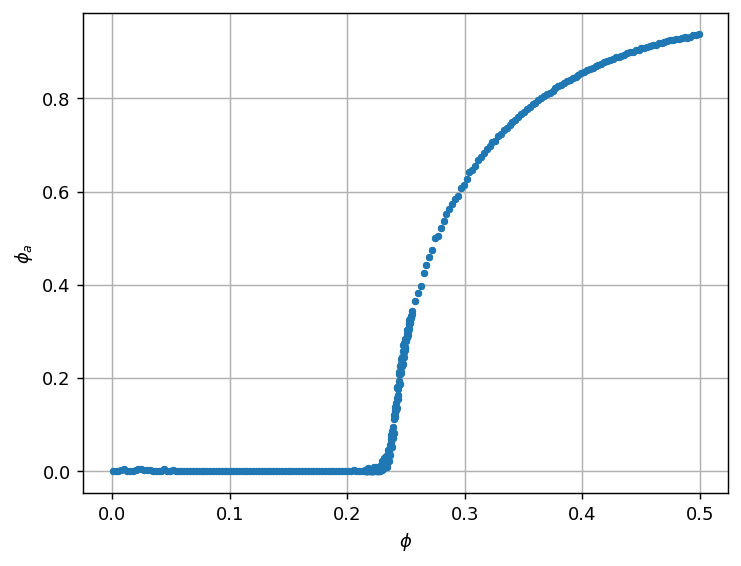

In [51]:
plt.figure(dpi=130)
plt.plot(PHI,PHI_A,'.',label='data')
# plt.plot(phi_near_above,phi_a_near_above,'.',label='data')
# plt.plot(phi_near_above,A*(phi_near_above-phi_c)**beta,'--',label=r'fit $\beta=2.17\pm0.08$')
# plt.axvline(phi_c_2, ls='--', label=r'$\phi_c$')
# plt.xlim(left=0.22,right=0.27)
plt.grid()
# plt.legend()
plt.ylabel(r'$\phi_a$')
plt.xlabel(r'$\phi$')
plt.savefig('plots/phi_a.png')
plt.show()

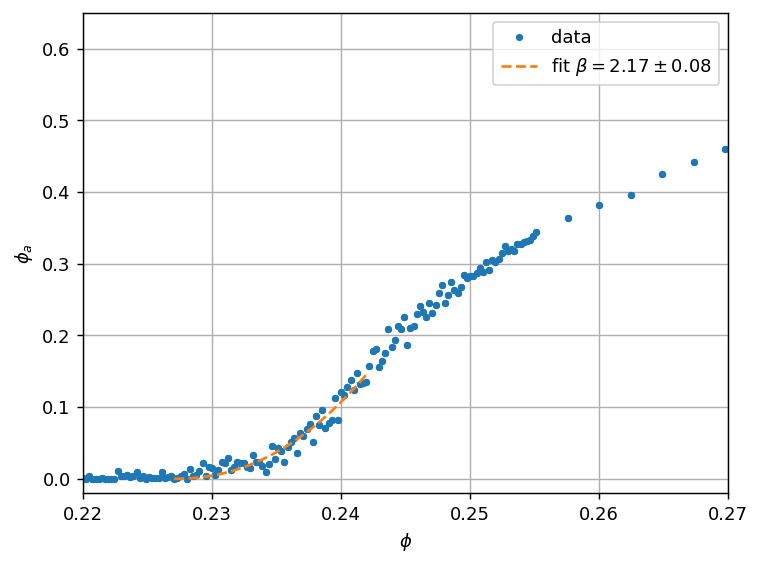

In [48]:
plt.figure(dpi=130)
plt.plot(PHI,PHI_A,'.',label='data')
# plt.plot(phi_near_above,phi_a_near_above,'.',label='data')
plt.plot(phi_near_above,A*(phi_near_above-phi_c)**beta,'--',label=r'fit $\beta=2.17\pm0.08$')
# plt.axvline(phi_c_2, ls='--', label=r'$\phi_c$')
plt.ylim(bottom=-0.02,top=0.65)
plt.xlim(left=0.22,right=0.27)
plt.grid()
plt.legend()
plt.ylabel(r'$\phi_a$')
plt.xlabel(r'$\phi$')
plt.savefig('plots/phi_a_fit1.png')
plt.show()

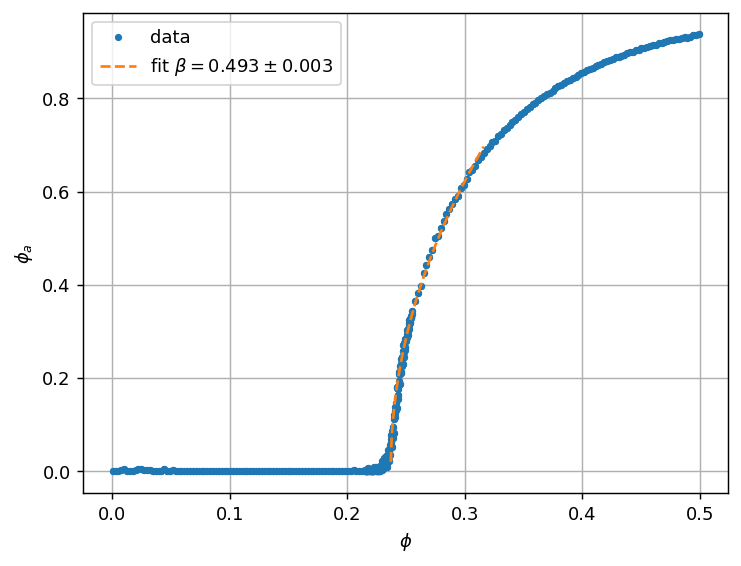

In [49]:
plt.figure(dpi=130)
plt.plot(PHI,PHI_A,'.',label='data')
# plt.plot(phi_near_above,phi_a_near_above,'.',label='data')
plt.plot(phi_near_above_3,A_3*(phi_near_above_3-phi_c_3)**beta_3,'--',label=r'fit $\beta=0.493\pm0.003$')
# plt.axvline(phi_c_2, ls='--', label=r'$\phi_c$')
# plt.xlim(left=0.22,right=0.27)
plt.grid()
plt.legend()
plt.ylabel(r'$\phi_a$')
plt.xlabel(r'$\phi$')
plt.savefig('plots/phi_a_fit2.png')
plt.show()

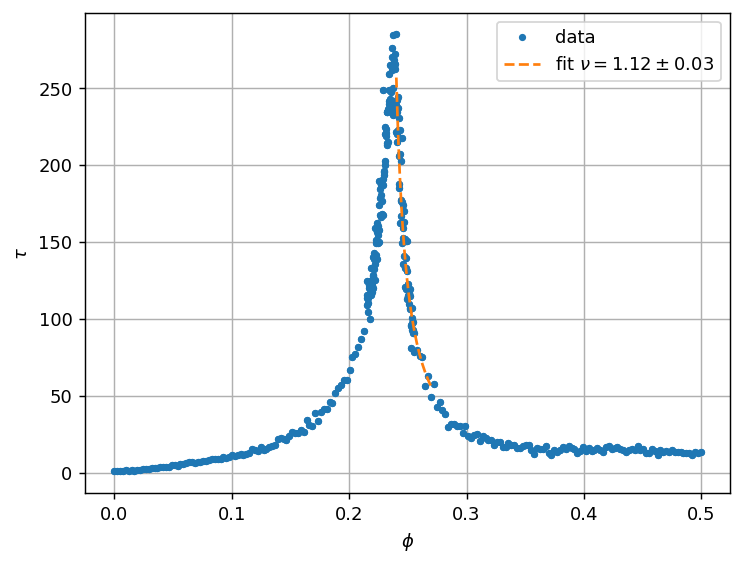

In [50]:
plt.figure(dpi=130)
plt.plot(PHI,T,'.',label='data')
plt.plot(phi_near_above_2,A2*(phi_near_above_2-c)**nu,'--',label=r'fit $\nu=1.12\pm0.03$')
# plt.xlim(left=phi_c_2-0.02,right=phi_c_2+0.15)
# plt.axvline(phi_c_2, ls='--', label=r'$\phi_c$')
plt.grid()
plt.legend()
plt.ylabel(r'$\tau$')
plt.xlabel(r'$\phi$')
plt.savefig('plots/tau')
plt.show()